# Workbook 6: Supervised Machine Learning

Overview of activities and objectives of this workbook:

1. The first part of this workbook will introduce the K Nearest Neighbour algorithm for supervised learning.
    - We will use the Iris dataset we introduced in the previous week.
    - You are provided code for 1NN (1 nearest neighbour) and will extend this, using generative AI, to KNN (k nearest neighbours).
    - We will also introduce several common Sklearn functions for splitting data into training and test sets, and visualising the results of classifiers.

2. The second part of this workbook will introduce Decision Trees, another supervised learning algorithm.
    - We will use the Sklearn implementation and explore how to limit tree growth (number/depth of branches) to prevent overfitting.

3. The third part HOW TO TEST THESE ALGORITHMS???

<div style="background-color:black;width:100%;"></div>

# Part 1: K nearest neighbours (KNN) <img src="figures/Iris-image.png" style="float:right">

First we will load the Iris data. This is a classic Machine Learning Data set which contains:
- 4 measurements (features): sepal and petal width and length
- 50 examples from each sub-species for iris flowers (so, 150 total)
- 3 class labels: Iris-Virginica, Iris-Setosa or Iris-Versicolor

The next cell to imports some useful libraries and then loads the iris dataset into two arrays:
- <code>irisX</code> (the features - 150 rows x 4 columns)
- <code>irisy</code> (the class labels - For the purpose of this tutorial we are going to ignore the fact that we are provided with class labels)
- We'll also make a list of the <code>feature_names</code> so we can use them to label our plots.
- Then we'll make a scatter plot to visualise the data.

Iris has 150 samples and 4 features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris has 3 classes: ['setosa' 'versicolor' 'virginica']


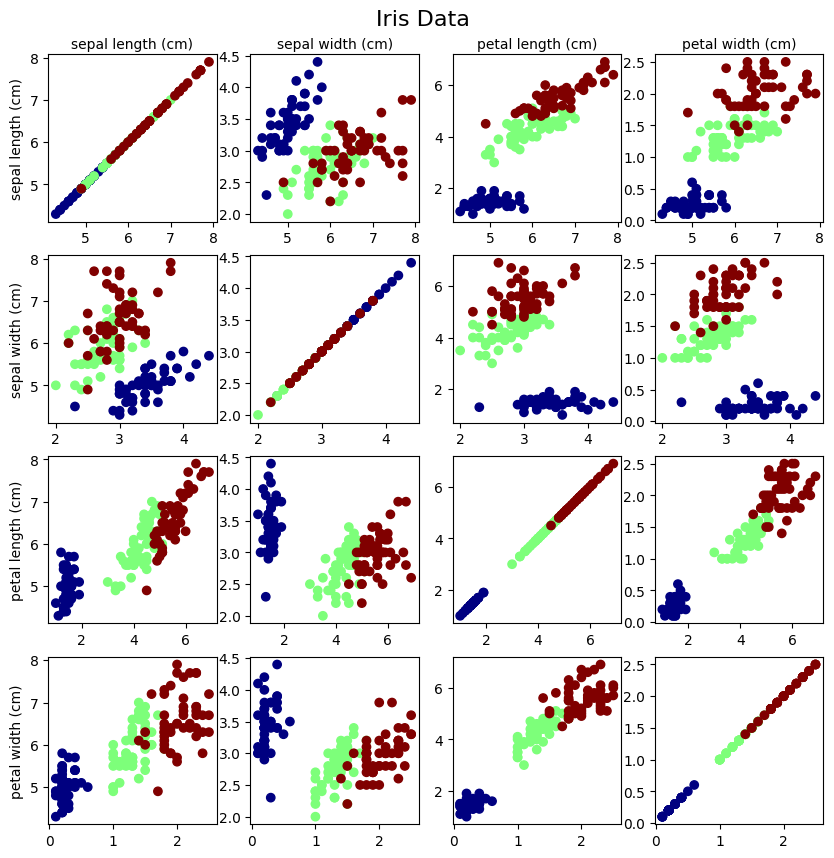

In [32]:
# load the data
import week6_utils as w6utils
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np

# Load the Iris data
iris_data = load_iris(return_X_y=False)
# Extract the data and labels, feature names, and label names
irisX = iris_data.data
irisy = iris_data.target
feature_names = iris_data.feature_names
label_names = iris_data.target_names

print(f"Iris has {irisX.shape[0]} samples and {irisX.shape[1]} features: {feature_names}")
print(f"Iris has 3 classes: {label_names}")

# Create a scatter plot of all the Iris data
w6utils.show_scatterplot_matrix(irisX, irisy, feature_names, "Iris Data")

## Implementing K-Nearest Neighbours

Implementations of supervised ML algorithms typically have two functions `fit()` and `predict()`.

'Fitting' -  means building/training the model with the training data, so that it (hopefully) makes good predictions.
   - With KNN this just means storing the training data.
   - But as we will see in future weeks this can also mean updating the model itself based on the quality of its predictions (e.g. with artificial neural networks).

Predicting - means using the model to make predictions e.g. the class of a particular data example.

For KNN predicting the label of a new example from the test set:
1. Measure distance to example point from every member of the training set.
2. Find the K Nearest Neighbours.  
   - In other words, the K members of the training set with the smallest distances (*calculated in step 1*)
3. Count the labels of those K training items and return the most common one as the predicted label.

Below is a figure illustrating the start and first two steps of process.  
It is followed by a code cell with a simple implementation of a class for 1-Nearest neighbours i.e. only consider the 1 closest neighbour. 

<b>Read through the code  to get a sense for how it implements the algorithm.</b><br>
Your tutor will discuss it with you in the lab sessions.
<img src="figures/kNN-steps.png">


<div class="alert alert-block alert-warning" style="color:black">
<b>Enumerating lists with python</b><br>
Quite often we may want to go through every item in a list and know:
<ul>
    <li> What the item is</li>
    <li> what position it is in (index)</li>
</ul>
We can do this in fewer lines of code by using python's built-in <code>enumerate</code> function.<br>
For example, this code snippet:<br>
<pre><code>my_list = ('a', 'b', 'c')
for idx, name in enumerate(my_list):
    print(idx , name)</code></pre>
produces the output:<br>
0 a<br>
1 b<br>
2 c<br>
</div>

In [33]:
class Simple1NNClassifier:
    """ Simple example class for 1-Nearest Neighbours algorithm.
    Assumes numpy is imported as np and uses euclidean distance
    """    
    def dist_a_b(self, a:np.array, b:np.array)->float:
        """ euclidean distance between same-size vectors a and b"""
        assert a.shape==b.shape, 'vectors not same size calculating distance'
        return np.linalg.norm(a-b) 
    
    def fit(self, x:np.ndarray, y:np.array):
        """ just stores the data for k-nearest neighbour"""
        self.model_x = x
        self.model_y = y
        self.is_fitted_=True
        
    def predict(self, new_items:np.ndarray):
        """ makes predictions for an array of new items"""

        # First item in  a numpy array's shape  is the number of rows
        # Get the number of new items and the number of stored items
        num_new = new_items.shape[0]
        num_stored = self.model_x.shape[0]
        
        # Create empty array to store predictions
        y_pred = np.zeros(num_new, dtype=int)
        
        # Measure distances - creates an array with one row for each new item and one column for each stored training example
        distances = np.zeros((num_new, num_stored))
        for row, new_item in enumerate(new_items):
            for col, stored_example in enumerate(self.model_x):
                distances[row][col]= self.dist_a_b(new_item, stored_example)

        # Make predictions - for each new example, find the stored example with the smallest distance
        for item_idx in range(num_new):
            y_pred[item_idx] = self.predict_one(item_idx, distances)
        
        # Return the predictions
        return y_pred
    
    def predict_one(self,item_idx:int, distances:np.ndarray):
        """ makes a class prediction for a single new item
        This version is just for 1 Nearest Neighbour
        Parameters
        ----------
        item_idx (int): item to make prediction for - i.e. idx of row in distances matrix
        dist (numpy ndarray): array of distances between new items (rows) and training set records(columns)
        """
        # We're going to use numpy's argmin() method (google it)
        # which gives us the get indexes of column with lowest value in an array
        idx_of_nearest_neighbour = np.argmin(distances[item_idx])

        # Return the predicted class of the nearest neighbour
        return self.model_y[ idx_of_nearest_neighbour]

## Applying KNN to the Iris data

We'll use the simple 1NN (K=1) classifier defined above and train and test on the Iris data we loaded previously.

The next few cells demonstrate how to do this using some Sklearn functions/classes.

### Split the data into train and test sets
- `test_size` argument specifies how much of the data to keep back for testing (0.33 for the iris data is 50 for testing and 100 for training).
- `stratify` argument makes sure our data has the same proportions of classes in train and test set (1:1:1 for the iris data set as this is *balanced*).

In [34]:
# Make train/test split of datasets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(irisX, irisy, test_size=0.33, stratify=irisy)

print(f'Training set has {train_x.shape[0]} examples, test set has {test_x.shape[0]} examples')

Training set has 100 examples, test set has 50 examples


### Create an instance of the model class then *fit*  it to the training data

In [35]:
my_1NN_model = Simple1NNClassifier()
my_1NN_model.fit(train_x, train_y)

### Evaluate the trained model's performance on unseen test data

In [36]:
# Make predictions for test data
predictions = my_1NN_model.predict(test_x)
print(f'Predictions are:\n {predictions}')


# Make array of True/False values for each prediction
# By comparing the predictions to the actual label values
print(f'Prediction matches to actual label values are:\n{test_y==predictions}')

# Calculate the accuracy
accuracy = 100 * (test_y == predictions).sum() / test_y.shape[0]
print(f"\nOverall Accuracy = {accuracy} %")

Predictions are:
 [0 2 0 1 2 0 0 1 1 0 1 2 2 2 0 2 2 2 0 0 0 2 1 1 1 0 2 1 0 2 2 0 2 1 1 1 0
 1 1 2 2 1 0 0 1 1 0 0 1 2]
Prediction matches to actual label values are:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True]

Overall Accuracy = 98.0 %


### Visualise a confusion matrix
A confusion matrix shows the counts of predictions vs the true label for each example. So correct predictions appear on the diagonal.

This is often more useful than just calculating accuracy because it shows where the classifier is making mistakes.

The Iris data is quite easy, so most models will make correct predictions for *setosa*  
but misclassify one or two instances of *versicolor* and *virginica*.

[]

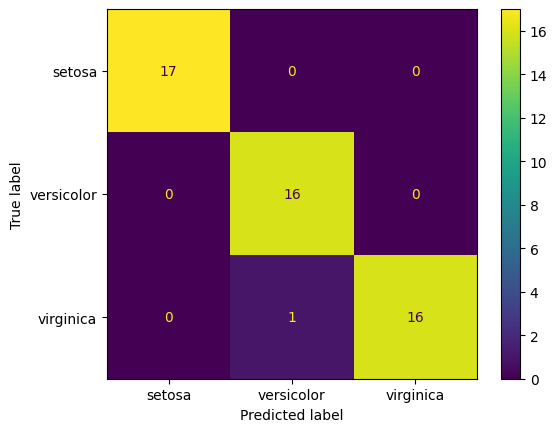

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_y, predictions, display_labels=label_names)
plt.plot()

### Visualise the decision boundary

The decision boundary shows how, within the 'decision space' the model is making predictions.

This can be useful to compare how different algorithms make decisions but is hard for most people to recognise in more than 2 dimensions.

So we will quickly train a model using a 2D version of the iris data set (just the petal measurements).


Overall Accuracy in 2D = 74.0%, model makes 13 mistakes


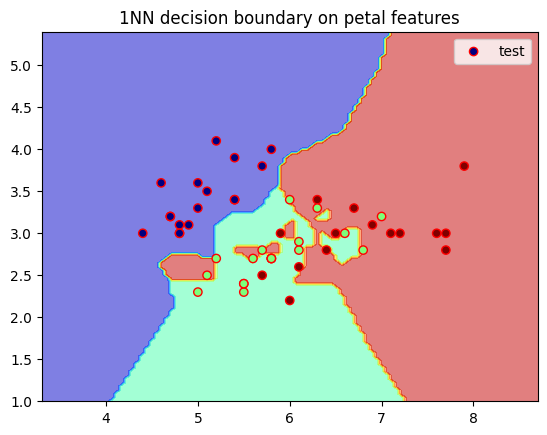

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

# Make data using numpy slicing to just pull the last two columns for every row
petal_trainx = train_x[:, :2]
petal_testx = test_x[:,: 2]

# Instantiate and fit model to data
my_1NN_2d = KNeighborsClassifier(n_neighbors=1)
my_1NN_2d.fit(petal_trainx, train_y)

# Make predictions, score them 
y_pred = my_1NN_2d.predict(petal_testx)
accuracy = 100 * ( test_y == y_pred).sum() / test_y.shape[0]
num_errors= len(y_pred) - (test_y == y_pred).sum()
print(f"Overall Accuracy in 2D = {accuracy}%, model makes {num_errors} mistakes")

# Create the decision boundary learned by model from training data
disp = DecisionBoundaryDisplay.from_estimator(my_1NN_2d, petal_trainx, alpha=0.5)

# Show where the test is within the decision boundary
disp.ax_.scatter(petal_testx[:, 0], petal_testx[:, 1], c=test_y, edgecolor='r', label='test')
disp.ax_.legend()
_= disp.ax_.set_title("1NN decision boundary on petal features")

<div class="alert alert-warning" style="color:black" >
<h2> Activity 2.2: Create your own implementation of K-Nearest Neighbours</h2>
    <p> Using the code above,  extend the predict method for the class Simple1NNClassifier  to use the votes from K>1 neighbours.</p>
    <ol>
        <li>Create a class that inherits most of the code: <code>class SimpleKNNClassifier (Simple1NNClassifier):</code> </li>
        <li> Create a new initialisation method that takes one parameter: the number of neighbours to consider(K)<br>
and saves it in <code>self.K</li>
        <li> Over-ride the <code>predict_one()</code> method <br>
        so that instead of just finding the label of the single closest neighbour it:
         <ol> 
             <li> Finds the indexes of the <code>self.K</code> nearest neighbours.<br>
                 HINT: you can replace <code>np.argmin</code> with <code>np.argpartition</code> <br>
                 <a href = https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array>
                 This question</a> is the same and the first answer is really useful.
             </li>
             <li>Stores the labels of these instances.<br>
                 The most general way to do with without making assumptions is to use a dictionary<br>
             but this will mean explicitly casting labels to strings to be safe</li>
             <li> Iterates through the labels to see which is most popular. <br>
             You may find the reminder below if you are not used to python dictionaries</li>
             <li> returns the most popular label as the prediction for item</li>
         </ol>
</div>

<div style="background:lightblue;color:black">
    <h3> Reminder: Storing data in python dictionaries and iterating through their contents</h3>
    <p> Python dictionaries are a way of storing data that can be accessed via a key<br>
for example: <code> my_dict= {'name':'jim','familyname':"Smith", 'job':'professor'}</code><br>
<b>Keys are usually strings</b>, but the values associated with a key can be any type, including numbers.</p>

<p> The following snippets of code might be useful to you - <b>after</b> you have edited them.</p>
<p> Make a new code cell in the notebook, copy the snippets in and run it, then edit it as you need.</p>
<p><pre style='background:lightblue;colour:black'>    
labels = ['a','b','a','c','a','d','b']
indexes = [1,4,6]
mydict={}
<span style="color:green">for</span> idx <span style="color:green">in</span> indexes:
    <span style="color:green">if</span> labels[idx] <span style="color:green">in</span> mydict.keys():
        mydict[labels[idx]] += 1
    <span style="color:green">else</span>: #create a new dictionary entry if needed
        mydict[labels[idx]] = 1
<span style="color:green">print</span>(f'mydict is {mydict}')

leastvotes=99
<span style="color:green">for</span> key,val <span style="color:green">in</span> mydict.items():
    <span style="color:green">if</span> val < leastvotes:
        unpopular= key
        leastvotes=val
<span style="color:green">print</span>(f'{unpopular}, {leastvotes}')
    </pre></p>
    </div>

In [ ]:
class SimpleKNNClassifier(Simple1NNClassifier):
    """Complete this class to produce a KNN classifier"""
    
    def __init__(self):
        """ your code here
        you will need to change the function signature to expect and store a parameter K
        """
        
    def predict_one(self, item_idx:int, distances:np.ndarray):
        """ makes a class prediction for a single new item
        You should write this to accept any number of neighbour K
        (stored in self.K)
        Parameters
        ----------
        item_idx (int): item to make prediction for - i.e. idx of row in distances matrix
        dist (numpy ndarray): array of distances between new items (rows) and training set records(columns)
        """
        prediction = -99999 #dummy value
        
        ### Insert your code below here
        
        
        ### Insert your code above here
        
        return prediction
        

<div class="alert alert-warning" style="color:black">
<h2> Activity 2.3: Test your implementation on the iris dataset</h2>
<p>Use the toolbar to copy and paste the second and third  cells from activity 2.1 below here. <br>
Then edit them so that they create and use objects of your new class, instead of the class Simple1NNClassifier.

Start with K=1 - this should produce   the same results as you got with my code in activity 2.1, then try with K = {3,5,7}
<ul>
    <li>Make  <b>qualititative</b> judgements : how does the decision surface change?</li>
    <li>Make <b>quantitative</b> judgements :  how does the confusion matrix change?</li>
    <li> In Machine Learning we talk about algorithms having  <b>hyper-parameters</b> that control their behaviour.<br>
        Adapt your code to investigate:
        <ul>
        <li>What value for the hyper-parameter <b>K</b> gives the best accuracy on the <b>test</b> set?</li>
        <li>What value for the hyper-parameter <b>K</b> gives the best accuracy on the <b>test</b> set?</li>
            <li> If these are not the same, can you explain why not?</li>
        </ul>
    </li>
    </ul>
    </div>

<div class="alert alert-danger" style="color:black">
    <h3>@Nathan: We need to write the bit about using co-pilot</h3>
    <p>My suggestion would be two things</p><ol>
    <li> For the iris test set,  make sure it makes identical predictions to an 
    instance of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">
    sklearn kNeighboursClassifier</a> </li>
    <li> Give them an easy to visualise dataset with a single feature: records with class 0 at vals 0,2,4,...50, records with class 1 at 55,60,65,70,...100<br>
    Test record at position 52.75 should be class 1 with K=1, class 0 with K=3, and so on</li></ol>
    </div>

<div class="alert alert-warning" style="color:black" >
<h1> Activity 3: Decision Trees</h1></div>

In the lecture notebook we illustrated how the decision tree is created by a process of expanding nodes.

We often want to control how we learn a model (in this case, grow a tree) h to avoid a phenomenon call **over-fitting**.

- This is where the model is capturing fine-details of the training set and so failing to generalise from the training set to the real world.
- like in the images where all the dogs faced left

<div class="alert alert-warning" style="color:black">
<h2> Activity 3.1: exploring how to control tree-growth to prevent over-fitting</h2>
The aim of this activity is for you to experiment with what happens when you change two <b>hyper-parameters</b> that affect how big and complex the tree is allowed to get.
<ul>
    <li> max_depth: default is None</li>
    <li>min_samples_leaf: default value is 1</li>
    </ul>


Experiment with the Iris data set we loaded earlier to see if you can work out what each of these hyper-parameters does, and how it affects the tree. 
<ul>
    <li> Do some combinations result in bigger differences between accuracy on the train / test sets?</li> 
<li> If you uncomment the first line after the imports, it will give you a different train-test split of the Iris data each time you run it.<br>
    Does this affect what tree you get? </li>
    <li> Is there a combination of hyper-parameter values that means you consistently get similar trees?</li>
    <li>    What is a good way of judging 'similarity?</li>
    </ul>
    </div>

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree


# do a new split of the data into into train:test
#train_x, test_x, train_y, test_y = train_test_split(iris_x, iris_y, test_size=0.33,stratify=iris_y)



## Experiment with changing these values
depth= 5 #  try 1,3,5
minleaf=3 #try 1,5

#make a model with those hyper-parameters
model = DecisionTreeClassifier(random_state=1234, max_depth=depth,min_samples_leaf=minleaf)
model.fit(train_x,train_y)

# evaluate on training and test sets

train_predictions= model.predict(train_x)
train_accuracy = 100* ( train_y == train_predictions).sum() / train_y.shape[0]

test_predictions = model.predict(test_x)
test_accuracy = 100* ( test_y == test_predictions).sum() / test_y.shape[0]
print(f"Overall Accuracy on train set = {train_accuracy} % and test set  = {test_accuracy} %")


#plot the confusion matrix and the tree side by side
#you may need to increase the figure size for larger trees
fig,axs= plt.subplots(ncols=2, figsize=(8,8)) 
CMPlot=ConfusionMatrixDisplay.from_predictions(test_y,predictions, display_labels=iris_names,colorbar=False, ax=axs[0])
_ = tree.plot_tree(model, feature_names=iris_features,  class_names=iris_names, filled=True,ax=axs[1])


<div class="alert alert-danger" style="color:black">
    <h3>@Nathan: Reduce the activity below to just doing one of KNN / DT?</h3>
    <p>As we re going to expand the activities above to include something about using co-pilot?</p>
    </div>

<div class="alert alert-warning" style="color:black" > <h1> Activity 4: Creating a test harness for comparing ML algorithms on a dataset</h1>
<p> Now you have done some manual experimenting with different hyper-parameter values for algorithms, it's time to think about automating that process.</p>
<p>Complete the cell below to create a method that: </p>
<ul>
    <li> Takes a train and test data  arrays as  parameters <br>
        HINT: develop your code using train_x, test_x,train_y,test_y for the iris data from above</li>
    <li> Runs your SimpleKNNClassifier with K={1,3,5,7,9} and stores the test accuracy for each <br>
    HINT: you could use:
        <ul>
            <li>a for loop to run the algorithm with different settings k  for  the number of neighbours(K),</li>
            <li> an <a href=https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/>f-string</a> e.g. <code>experiment_name= f'KNN_K={k}'</code> to create a meaningful name for each run </li>
            <li>a   dictionary to store your results, where each experiment has the string <em>experiment_name</em> as the key and the accuracy as the value </li>
            </ul>for this?</li>
    <li> Runs a DecisionTreeClassifier with all the different combinations of hyper-parameters from activity 3<br>
       HINT: You could do this in the same way as I've suggested above but with nested for-loops (one for each hyper-parameter) and a more complex python f-string to create the name (key), then store the results in the same dictionary.  </li>
    <li> Reports the results and which algorithm-hyperparameter combination has the highest test accuracy</li>
</ul>
</div>


In [ ]:
def first_ml_test_harness(train_x:np.ndarray,train_y:np.ndarray,
                          test_x:np.ndarray,test_y:np.ndarray):
    """ code to compare supervised machine learning algorithms on a dataset"""
    # insert your code below here
    
    
    
    print('not implemented yet')
    #insert your code above here

In [ ]:
#now run your code for the iris data
first_ml_test_harness(train_x, train_y)

<div class="alert alert-block alert-danger"> Please save your work (click the save icon) then shutdown the notebook when you have finished with this tutorial (menu->file->close and shutdown notebook</div>

<div class="alert alert-block alert-danger"> Remember to download and save your work if you are not running this notebook locally.</div>